Bibliotecas

In [2]:
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow

Métricas

In [3]:
def MSE(img1, img2):
    return np.mean((img1 - img2) ** 2)

def RMSE(img1, img2):
    return np.sqrt(MSE(img1, img2))

def PSNR(img1, img2):
    mse = MSE(img1, img2)
    if (mse == 0):
        return 100

    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return psnr

Filtros espaciais

In [4]:
def apply_gaussian_blur(img):
    kernel = np.array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
        ]) / 16
    img_height, img_width = img.shape

    padded_img = np.pad(img, pad_width=1, mode='edge')
    output_img = np.zeros((img_height, img_width), dtype=float)

    for i_img in range(1, img_height + 1):
        for j_img in range(1, img_width + 1):
            output_img[i_img-1, j_img-1] = np.sum(
                padded_img[
                    i_img-1:i_img+2,
                    j_img-1:j_img+2
                ] * kernel
            )

    return np.array(output_img, dtype=np.uint8)

In [5]:
def apply_sobel(img):
    kernel_x = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
        ])
    kernel_y = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
        ])
    img_height, img_width = img.shape

    padded_img = np.pad(img, pad_width=1, mode='edge')
    output_img = np.zeros((img_height, img_width), dtype=float)

    for i_img in range(1, img_height + 1):
        for j_img in range(1, img_width + 1):
            output_img[i_img-1, j_img-1] = int(
                np.abs(np.sum(
                    padded_img[
                        i_img-1:i_img+2,
                        j_img-1:j_img+2
                    ] * kernel_x
                )) +
                np.abs(np.sum(
                    padded_img[
                        i_img-1:i_img+2,
                        j_img-1:j_img+2
                    ] * kernel_y
                ))
            )

    return np.array(output_img, dtype=np.float32)

Filtros de frequência

In [6]:
def get_magnitude_spectrum(img):
    img_float32 = np.float32(img)
    dft = cv2.dft(img_float32, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    magnitude_spectrum = np.abs(magnitude_spectrum)
    magnitude_spectrum -= magnitude_spectrum.min()
    magnitude_spectrum = magnitude_spectrum*255 / magnitude_spectrum.max()
    magnitude_spectrum = magnitude_spectrum.astype(np.uint8)
    return magnitude_spectrum

In [7]:
def apply_low_pass(shape, center, radius, isIdeal):
    rows, cols = shape[:2]
    r, c = np.mgrid[0:rows:1, 0:cols:1]
    c -= center[0]
    r -= center[1]
    d = np.power(c, 2.0) + np.power(r, 2.0)
    lpFilter_matrix = np.zeros(shape, np.float32)
    if isIdeal:  # ideal low-pass filter
        lpFilter = np.copy(d)
        lpFilter[lpFilter < pow(radius, 2.0)] = 1
        lpFilter[lpFilter >= pow(radius, 2.0)] = 0
    else: # Gaussian low pass filter
        lpFilter = np.exp(-d/(2*pow(radius, 2.0)))
    lpFilter_matrix[:, :, 0] = lpFilter
    lpFilter_matrix[:, :, 1] = lpFilter
    return lpFilter_matrix

In [8]:
def apply_high_pass(shape, center, radius, isIdeal):
    rows, cols = shape[:2]
    r, c = np.mgrid[0:rows:1, 0:cols:1]
    c -= center[0]
    r -= center[1]
    d = np.power(c, 2.0) + np.power(r, 2.0)
    lpFilter_matrix = np.zeros(shape, np.float32)
    if isIdeal:  # Ideal high pass filter
        lpFilter = np.copy(d)
        lpFilter[lpFilter < pow(radius, 2.0)] = 0
        lpFilter[lpFilter >= pow(radius, 2.0)] = 1
    else: # Gaussian Highpass Filter
        lpFilter = 1.0 - np.exp(-d/(2*pow(radius, 2.0)))
    lpFilter_matrix[:, :, 0] = lpFilter
    lpFilter_matrix[:, :, 1] = lpFilter
    return lpFilter_matrix

In [9]:
def apply_frequency_filter(img, radius, isHighPass, isIdeal):
  image_f32 = np.float32(img)
  dft = cv2.dft(image_f32, flags = cv2.DFT_COMPLEX_OUTPUT)
  dft_shift = np.fft.fftshift(dft)

  center = (img.shape[1]//2, img.shape[0]//2)

  if isHighPass:
    mask = apply_high_pass(dft_shift.shape, center, radius, isIdeal)
  else:
    mask = apply_low_pass(dft_shift.shape, center, radius, isIdeal)

  filtered_freq = dft_shift*mask
  f_ishift = np.fft.ifftshift(filtered_freq) #inversa da fft
  img_back = cv2.idft(f_ishift) #inversa da dft
  img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1]) #recuperando a imagem capturando a magnitude (intesidade)

  img_back = np.array(img_back, dtype=np.float32)

  filtered_img = np.abs(img_back)
  filtered_img -= filtered_img.min()
  filtered_img = filtered_img*255 / filtered_img.max()
  return filtered_img.astype(np.uint8)

Aplicação de filtro com mensuração de tempo médio

In [10]:
def apply_and_measure_filter_mean_time(iterations, func):
  ms_spent = 0
  for i in range(iterations):
    start = time.time()
    img_with_filter = func()
    ms_spent += time.time() - start
  return (img_with_filter, ms_spent * 1000 / iterations)

main

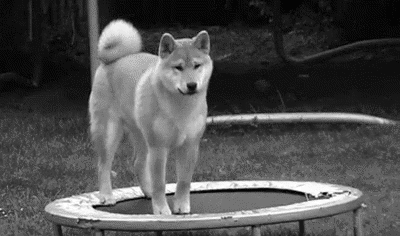

In [12]:
img = cv2.imread('/content/image.png', 0)
cv2_imshow(img)

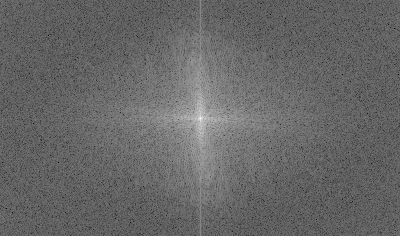

In [ ]:
cv2_imshow(get_magnitude_spectrum(img))

Esmaecimento Gaussiano x Low Pass

Esmaecimento Gaussiano: 790.7491207122803 ms


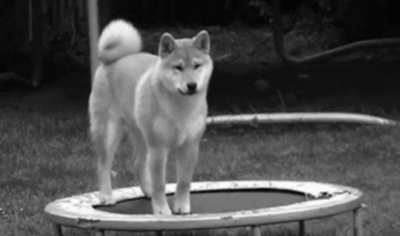

Low Pass Ideal: 16.929912567138672 ms


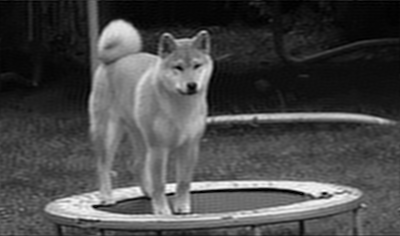

Low Pass Gaussiano: 17.495346069335938 ms


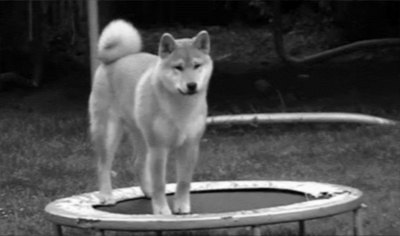

In [ ]:
gaussian_blur_img, ms_spent = apply_and_measure_filter_mean_time(
    5,
    lambda: apply_gaussian_blur(img)
)
print(f'Esmaecimento Gaussiano: {ms_spent} ms')
cv2_imshow(gaussian_blur_img)

ideal_lp_img, ms_spent = apply_and_measure_filter_mean_time(
    5,
    lambda: apply_frequency_filter(img, 70, isHighPass=False, isIdeal=True)
)
print(f'Low Pass Ideal: {ms_spent} ms')
cv2_imshow(ideal_lp_img)

gaussian_lp_img, ms_spent = apply_and_measure_filter_mean_time(
    5,
    lambda: apply_frequency_filter(img, 70, isHighPass=False, isIdeal=False)
)
print(f'Low Pass Gaussiano: {ms_spent} ms')
cv2_imshow(gaussian_lp_img)

In [ ]:
print('Gaussian Blur x Low Pass:\n')

print('MSE:')
print(f'Gaussian Blur x Ideal LP:\t{MSE(gaussian_blur_img, ideal_lp_img)}')
print(f'Gaussian Blur x Gaussian LP:\t{MSE(gaussian_blur_img, gaussian_lp_img)}')

print('\nRMSE:')
print(f'Gaussian Blur x Ideal LP:\t{RMSE(gaussian_blur_img, ideal_lp_img)}')
print(f'Gaussian Blur x Gaussian LP:\t{RMSE(gaussian_blur_img, gaussian_lp_img)}')

print('\nPSNR:')
print(f'Gaussian Blur x Ideal LP:\t{PSNR(gaussian_blur_img, ideal_lp_img)}')
print(f'Gaussian Blur x Gaussian LP:\t{PSNR(gaussian_blur_img, gaussian_lp_img)}')


Gaussian Blur x Low Pass:

MSE:
Gaussian Blur x Ideal LP:	42.816504237288136
Gaussian Blur x Gaussian LP:	9.58385593220339

RMSE:
Gaussian Blur x Ideal LP:	6.543432145081672
Gaussian Blur x Gaussian LP:	3.0957803430158592

PSNR:
Gaussian Blur x Ideal LP:	31.814691545286085
Gaussian Blur x Gaussian LP:	38.3154008423663


Sobel x High Pass

Sobel: 1906.1058044433594 ms


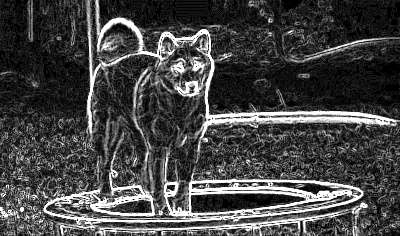

High Pass Ideal: 17.71416664123535 ms


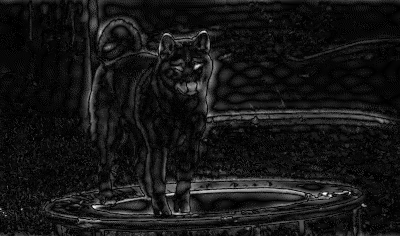

High Pass Gaussiano: 17.86203384399414 ms


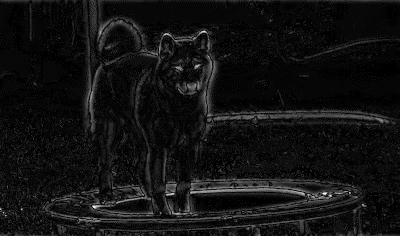

Canny: 2.1616458892822266 ms


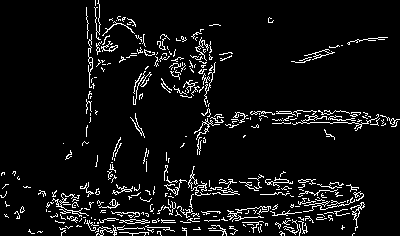

In [14]:
sobel_img, ms_spent = apply_and_measure_filter_mean_time(
    5,
    lambda: apply_sobel(img)
)
print(f'Sobel: {ms_spent} ms')
cv2_imshow(sobel_img)

ideal_hp_img, ms_spent = apply_and_measure_filter_mean_time(
    5,
    lambda: apply_frequency_filter(img, 15, isHighPass=True, isIdeal=True)
)
print(f'High Pass Ideal: {ms_spent} ms')
cv2_imshow(ideal_hp_img)

gaussian_hp_img, ms_spent = apply_and_measure_filter_mean_time(
    5,
    lambda: apply_frequency_filter(img, 15, isHighPass=True, isIdeal=False)
)
print(f'High Pass Gaussiano: {ms_spent} ms')
cv2_imshow(gaussian_hp_img)

canny_img, ms_spent = apply_and_measure_filter_mean_time(
    5,
    lambda: cv2.Canny(sobel_img.astype(np.uint8), 400, 800)
)
print(f'Canny: {ms_spent} ms')
cv2_imshow(canny_img)

In [15]:
print('Canny x Sobel and High Pass:\n')

print('MSE:')
print(f'Canny x Sobel:\t\t{MSE(canny_img, sobel_img)}')
print(f'Canny x Ideal HP:\t{MSE(canny_img, ideal_hp_img)}')
print(f'Canny x Gaussian HP:\t{MSE(canny_img, gaussian_hp_img)}')

print('\nRMSE:')
print(f'Canny x Sobel:\t\t{RMSE(canny_img, sobel_img)}')
print(f'Canny x Ideal HP:\t{RMSE(canny_img, ideal_hp_img)}')
print(f'Canny x Gaussian HP:\t{RMSE(canny_img, gaussian_hp_img)}')

print('\nPSNR:')
print(f'Canny x Sobel:\t{PSNR(canny_img, sobel_img)}')
print(f'Canny x Ideal HP:\t{PSNR(canny_img, ideal_hp_img)}')
print(f'Canny x Gaussian HP:\t{PSNR(canny_img, gaussian_hp_img)}')


Canny x Sobel and High Pass:

MSE:
Canny x Sobel:		16540.974609375
Canny x Ideal HP:	86.54406779661016
Canny x Gaussian HP:	75.27583686440678

RMSE:
Canny x Sobel:		128.61172485351562
Canny x Ideal HP:	9.302906416631856
Canny x Gaussian HP:	8.676164870748295

PSNR:
Canny x Sobel:	5.945192354011662
Canny x Ideal HP:	28.7584305655359
Canny x Gaussian HP:	29.364247684722375
